## **To recreate study results please load package versions found in main_requirements.txt**

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.8.3 pynndescent==0.5.13


In [5]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc

## **Load raw UMI count data**

In [7]:
# read in count matrices post nuclei and gene quality control
adata = sc.read( "../data/Processed_data_RNA-all_full-counts-and-downsampled-CPM.h5ad")

In [8]:
# read in adata post clustering and dev-traj assignment
adata2 = sc.read_h5ad( "../data/Processed_data_RNA-gaba_full-counts-and-downsampled-CPM.h5ad")

In [9]:
adata.obs_names.values

array(['AAACCTGAGAGTCGGT-RL1612_34d_v2', 'AAACCTGAGCCGCCTA-RL1612_34d_v2',
       'AAACCTGAGTCGAGTG-RL1612_34d_v2', ...,
       'TTTGTTGGTAAGGTCG-RL2132_25yr_v3',
       'TTTGTTGGTTCGGCTG-RL2132_25yr_v3',
       'TTTGTTGTCGTCCTCA-RL2132_25yr_v3'], dtype=object)

In [10]:
# add obs and obsm data to matching raw count nuclei
adata = adata[nmc.member_test( adata.obs_names.values, adata2.obs_names.values)]
adata.obs = adata2.obs
adata.obsm = adata2.obsm
adata.uns = adata2.uns
sc.pp.calculate_qc_metrics( adata, inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# check if order of BCs match, should sum to 0
(adata.obs_names.values!=adata2.obs_names.values).sum()

0

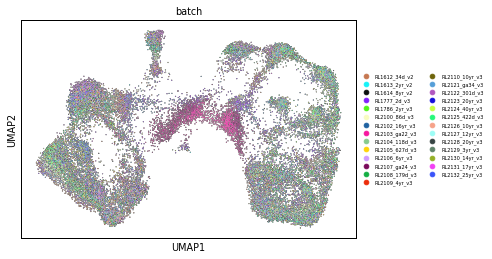

In [12]:
sc.pl.umap( adata, color=['batch'], legend_fontsize=5, add_outline=True, size=2, legend_fontoutline=0.5)

## **Clean up features a bit**

In [13]:
# change unknown NaNs in year collected to common date
adata.obs['Collection_year'].fillna( 9999, inplace=True)

/var/folders/cy/tl1lfdqj7rd2_tx7n2kj_vdr0000gn/T/ipykernel_37629/3648978272.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['Collection_year'].fillna( 9999, inplace=True)


In [14]:
# get list of batches
batches = adata.uns['batch_order']

## **Bulk by batch**

In [15]:
!mkdir ../data/limma-voom/

In [16]:
# set minimum number of nuclei needed to make a bulk data set
min_cells = 10
# create dataframe to hold bulked data
batches = adata.uns['batch_order']
columns = [ ("--").join((x,y)) for x,y in zip( adata.var['gene_ids'].values, adata.var_names.values)]#
bulk = pd.DataFrame( index=batches, columns=columns)
# only want obs that are same across the batch, i.e. what can be controlled for
obs_col_mk = (adata.obs.nunique()<=len(batches)).values
obs_cols = np.array( adata.obs_keys())[obs_col_mk]
# drop all dev_traj observations
obs_cols = [ii for ii in obs_cols if 'traj' not in ii]
obs = pd.DataFrame(  index=batches, columns=obs_cols)
obs['Num_Cells'] = 0
# loop through batches
for batch_itr in batches:
    ind = batch_itr
    batch_mk = adata.obs['batch'].values==batch_itr
    num_cells = batch_mk.sum()
    if( min_cells<10):
        bulk.drop( ind, axis=0, inplace=True)
        obs.drop(  ind, axis=0, inplace=True)
        continue
    else:
        batch_adata = adata[batch_mk]
        bulk.loc[ind] = batch_adata.X.sum(0).A1
        obs.loc[ind,'Num_Cells'] = num_cells
        obs.loc[ind,obs_cols] = batch_adata.obs.iloc[0,obs_col_mk]

# save files
bulk.T.to_csv( f"../data/limma-voom/bulked-by-batch_pseudo-bulk-cts_min{min_cells}.csv")
obs.to_csv(  f"../data/limma-voom/bulked-by-batch_obs-cts_min{min_cells}.csv")

In [17]:
# example output, un-transposed
obs.head()

,batch,RL#,age,chem,concat_id,numerical_age,stage_id,Sex,Race,PMI,...,Oxygen/No Oxygen,Date-of-Collection,Collection_year,Library Prep Date,Library Prep Lot,mat/dev,cell_type,major_clust,downstream_dev_clusts,Num_Cells
RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,Oxygen,nan,9999.0,28.03.2020,1,dev,CGE,CGE_dev,root,1336
RL2107_ga24_v3,RL2107_ga24_v3,RL2107,ga24,v3,11,-0.306849,Fetal,M,AA,9,...,No Oxygen,nan,9999.0,28.03.2020,1,dev,MGE,MGE_dev,root,1278
RL2121_ga34_v3,RL2121_ga34_v3,RL2121,ga34,v3,15,-0.115068,Fetal,F,White,23,...,No Oxygen,11.01.2015,2015.0,16.04.2020,2,mat,MGE,SST,"MGE_dev-2,MGE_dev-1",1344
RL1777_2d_v3,RL1777_2d_v3,RL1777,2d,v3,3,0.005479,Neonatal,F,White,26,...,Oxygen,7.22.2013,2013.0,27.06.2019,4,mat,MGE,ID2,MGE_dev-1,1638
RL1612_34d_v2,RL1612_34d_v2,RL1612,34d,v2,0,0.093151,Neonatal,M,AA,5,...,Oxygen,10.04.2011,2011.0,20.11.2018,5,dev,MGE,SST,"MGE_dev-2,MGE_dev-1",1802


In [18]:
# example output, un-transposed
bulk.head()

,ENSG00000238009--RP11-34P13.7,ENSG00000237683--AL627309.1,ENSG00000239906--RP11-34P13.14,ENSG00000228463--AP006222.2,ENSG00000237094--RP4-669L17.10,ENSG00000235146--RP5-857K21.2,ENSG00000230021--RP5-857K21.4,ENSG00000235373--RP11-206L10.3,ENSG00000240618--RP11-206L10.5,ENSG00000228327--RP11-206L10.2,...,ENSG00000218497--ZNF84-1,ENSG00000229631--AL603926.1,ENSG00000220023--AL592183.1,ENSG00000212884--AC011841.1,ENSG00000215615--AL354822.1,ENSG00000268276--AL590523.1,ENSG00000215700--PNRC2-1,ENSG00000215699--SRSF10-1,ENSG00000215635--AC145205.1,ENSG00000251180--CU459201.1
RL2103_ga22_v3,1.0,0.0,0.0,59.0,41.0,2.0,149.0,0.0,1.0,14.0,...,3.0,7.0,451.0,0.0,0.0,0.0,2.0,43.0,0.0,0.0
RL2107_ga24_v3,1.0,0.0,0.0,34.0,29.0,0.0,125.0,0.0,1.0,2.0,...,2.0,0.0,284.0,0.0,55.0,1.0,1.0,23.0,2.0,1.0
RL2121_ga34_v3,2.0,0.0,1.0,25.0,131.0,0.0,42.0,3.0,1.0,12.0,...,0.0,3.0,470.0,0.0,4.0,0.0,2.0,20.0,4.0,0.0
RL1777_2d_v3,6.0,5.0,1.0,157.0,104.0,0.0,449.0,3.0,2.0,16.0,...,11.0,11.0,806.0,0.0,166.0,0.0,10.0,186.0,12.0,0.0
RL1612_34d_v2,3.0,1.0,0.0,89.0,59.0,0.0,73.0,0.0,2.0,0.0,...,3.0,1.0,518.0,0.0,2.0,0.0,3.0,42.0,0.0,1.0
